### CNN on the FULL Cats-v-dogs dataset  

It is recommended to run this notebook in colab

In [1]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
import numpy as np
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

THe next code block downloads the full Cats-v-Dogs dataset and stores it as  cats-and-dogs.zip. It then unzips it to `/tmp ` which will create a tmp/PetImages directory containing subdirectories called 'Cat' and 'Dog' (that's how the original researchers structured it)

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-12-02 17:53:20--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.228.51, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|173.222.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   115MB/s    in 6.9s    

2020-12-02 17:53:27 (114 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [4]:
# We need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

Now, this function takes a SOURCE directory containing the files  a TRAINING directory that a portion of the files will be copied to a TESTING directory 
that a portion of the files will be copie to a SPLIT SIZE to determine the portion for example, if SOURCE is `PetImages/Cat`, and SPLIT SIZE is .9

Then 90% of the images in `PetImages/Cat` will be copied to the TRAINING dir and 10% of the images will be copied to the TESTING dir

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset=[]
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if (os.path.getsize(data) > 0):
            dataset.append(unitData)
        else: 
            print('Skiped' + unitData )
    
    
    trainDatasetLenght =  int(len(dataset)*SPLIT_SIZE)
    testDatasetLenght  =  int(len(dataset)- trainDatasetLenght)
    shuffledSet = random.sample( (dataset), len(dataset) )
    trainSet= shuffledSet[0:trainDatasetLenght]
    testSet = shuffledSet[-testDatasetLenght:]
    
    for unitData in trainSet:
        tempTrainData = SOURCE + unitData
        finalTrainData = TRAINING + unitData
        copyfile(tempTrainData, finalTrainData)
    
    for unitData in testSet:
        tempTestData = SOURCE + unitData
        finalTestData = TESTING + unitData
        copyfile(tempTestData, finalTestData)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

Skiped666.jpg
Skiped11702.jpg


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

12374
12366
2374
2366


In [8]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(124, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
TRAINING_DIR = "/tmp/cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale=1.0/255)

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    class_mode='binary', 
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.
validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         class_mode='binary', 
                                                         target_size=(150, 150))

# Expected Output:
# Found 2700 images belonging to 2 classes.
# Found 300 images belonging to 2 classes.

Found 24738 images belonging to 2 classes.
Found 4739 images belonging to 2 classes.


In [10]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)




Epoch 1/15
2474/2474 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.6660

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2474/2474 [==============================] - 92s 37ms/step - loss: 0.6031 - accuracy: 0.6660 - val_loss: 0.5080 - val_accuracy: 0.7531
Epoch 2/15
2474/2474 [==============================] - 93s 38ms/step - loss: 0.4863 - accuracy: 0.7684 - val_loss: 0.4425 - val_accuracy: 0.7989
Epoch 3/15
2474/2474 [==============================] - 92s 37ms/step - loss: 0.4158 - accuracy: 0.8100 - val_loss: 0.3707 - val_accuracy: 0.8344
Epoch 4/15
2474/2474 [==============================] - 90s 36ms/step - loss: 0.3613 - accuracy: 0.8407 - val_loss: 0.3130 - val_accuracy: 0.8637
Epoch 5/15
2474/2474 [==============================] - 91s 37ms/step - loss: 0.3178 - accuracy: 0.8626 - val_loss: 0.2475 - val_accuracy: 0.8941
Epoch 6/15
2474/2474 [==============================] - 90s 36ms/step - loss: 0.2769 - accuracy: 0.8831 - val_loss: 0.2256 - val_accuracy: 0.9076
Epoch 7/15
2474/2474 [==============================] - 89s 36ms/step - loss: 0.2400 - accuracy: 0.9010 - val_loss: 0.1895 - val_accura

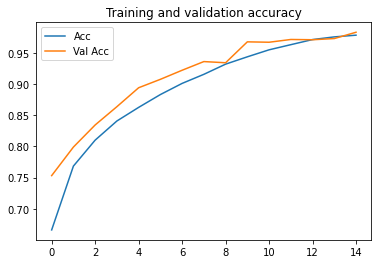

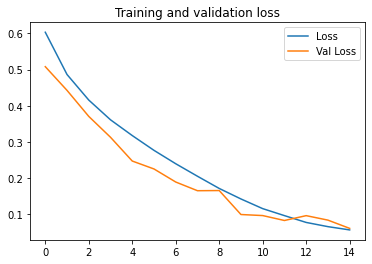

In [11]:
# PLOT LOSS AND ACCURACY
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#history is the name of the model
acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history[ 'val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot  ( epochs,     acc , label= 'Acc')
plt.plot  ( epochs, val_acc , label= 'Val Acc')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label = 'Loss')
plt.plot  ( epochs, val_loss , label='Val Loss')
plt.title ('Training and validation loss'   )
plt.legend()

Saving cat.2417.jpg to cat.2417.jpg


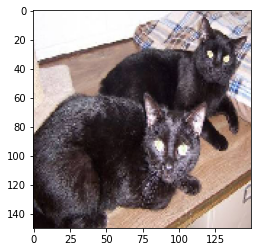

[0.]
cat.2417.jpg is a cat


In [16]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")


    